In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from multiprocessing import Pool

In [2]:
# Load data
# Load data
df = pd.read_csv('AAPL.csv')
close_prices = df['Close']

# Calculate 10-day moving average and round it
df['10_day_MA'] = close_prices.rolling(window=10).mean().round(decimals=0)

In [3]:
def historic_volatility_frequentist(data):
    """
    Calculate the annualized volatility of stock prices.

    Parameters:
    data (DataFrame): A pandas DataFrame with a 'Close' column representing closing stock prices.

    Returns:
    float: The annualized volatility, based on daily stock price changes.
    """
    # Calculate logarithmic returns of closing prices
    log_returns = np.log(data['Close'] / data['Close'].shift(1))

    # Calculate the standard deviation (volatility) of these returns
    std_dev = log_returns.std()

    # Annualize the volatility (assuming 252 trading days in a year)
    annualized_volatility = std_dev * np.sqrt(252)

    return annualized_volatility

In [4]:
N = norm.cdf

def vectorized_BS_CALL(S0, K, T, r, sigma):
    """
    Vectorized implementation of the Black-Scholes formula for call option pricing.

    Parameters:
    S0 (float): Current stock price.
    K (float): Strike price of the option.
    T (float): Time to expiration in years.
    r (float): Risk-free interest rate.
    sigma (float): Volatility of the underlying stock.

    Returns:
    float: The Black-Scholes call option price.
    """
    # Calculating d1 and d2 using Black-Scholes formula components
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

In [16]:
import numpy as np

def mh_call_option_pricing_optimized(S0, K, T, r, sigma, n_simulations):
    n_steps = int(365 * T)  # Total number of time steps
    synthetic_call_prices = np.zeros(n_simulations)  # Initialize array for call option payouts

    for i in range(n_simulations):
        S = np.zeros(n_steps)  # Initialize array for stock prices
        S[0] = S0  # Set initial stock price

        for t in range(1, n_steps):
            S_current = S[t-1]
            dE = (r - 0.5 * sigma**2) * (T/n_steps) + sigma * np.sqrt(T/n_steps) * np.random.randn()
            S_new = S_current * np.exp(dE)  # Proposed new stock price

            # Calculate target probabilities for current and new stock prices
            target_current = np.exp(-0.5 * ((S_current - S0) / sigma)**2)
            target_new = np.exp(-0.5 * ((S_new - S0) / sigma)**2)

            # Calculate acceptance probability
            A = min(1, target_new / target_current)

            # Accept or reject the new stock price
            if np.random.rand() < A:
                S[t] = S_new
            else:
                S[t] = S_current

        # Calculate and store the call option payout
        synthetic_call_prices[i] = np.exp(-r * T) * max(S[-1] - K, 0)

    # Return the average of all simulated call option payouts
    return np.mean(synthetic_call_prices)

In [17]:
def mh_simulation(args):
    """
    Function for running a parallel Metropolis-Hastings simulation for option pricing.

    This function serves as a wrapper for the 'mh_call_option_pricing_optimized' function,
    enabling parallel execution of multiple simulations. It unpacks the provided arguments 
    and invokes the MH option pricing function. This approach is beneficial for 
    computationally intensive tasks, allowing for efficient use of multiple processors.

    Parameters:
    args (tuple): A tuple of parameters required for the Metropolis-Hastings simulation.
                  This tuple contains:
                  - S (float): Current stock price.
                  - K (float): Strike price of the option.
                  - T (float): Time to expiration in years.
                  - r (float): Risk-free interest rate.
                  - sigma (float): Volatility of the underlying stock.
                  - n_simulations (int): Number of simulations to perform.

    Returns:
    float: The estimated price of the call option calculated by the Metropolis-Hastings algorithm.
    """
    # Unpack the parameters from the argument tuple
    S, K, T, r, sigma, n_simulations = args

    # Execute the Metropolis-Hastings simulation for option pricing with the provided parameters
    return mh_call_option_pricing_optimized(S, K, T, r, sigma, n_simulations)


In [18]:
import time

# Main Execution Block

print("Starting main execution...")

# Prepare the data by removing rows with any NaN values
df = df.dropna()
print("Data preparation complete.")

# Define parameters for the option pricing models.
T = 0.25  # Time to maturity in years.
r = 0.05  # Risk-free interest rate, assumed constant for simplicity.
sigma = historic_volatility_frequentist(df)  # Calculated historical volatility of the stock.
print(f"Parameters set: T={T}, r={r}, sigma={sigma}")

# Set the number of simulations for the Metropolis-Hastings algorithm.
n_simulations = 10
print("Starting vectorized calculation for Black-Scholes prices...")

# Vectorized calculation of Black-Scholes option prices.
df['BS Price'] = vectorized_BS_CALL(df['Close'], df['10_day_MA'], T, r, sigma)
print("Black-Scholes price calculation complete.")

Starting main execution...
Data preparation complete.
Parameters set: T=0.25, r=0.05, sigma=0.2288867870931986
Starting vectorized calculation for Black-Scholes prices...
Black-Scholes price calculation complete.


In [19]:
import time
import numpy as np

# Main Execution Block
data_cleaned = df
print("Starting main execution...")

# Define parameters for the option pricing models.
T = 0.25  # Time to maturity in years.
r = 0.05  # Risk-free interest rate, assumed constant for simplicity.
sigma = historic_volatility_frequentist(data_cleaned)  # Calculated historical volatility of the stock.

# Set the number of simulations for the Metropolis-Hastings algorithm.
n_simulations = 1000

print(f"Parameters set: T={T}, r={r}, sigma={sigma}")

print("Starting Metropolis-Hastings simulations...")

# Perform the Metropolis-Hastings simulations using a standard loop.
start_time = time.time()  # Record the start time

# Initialize a numpy array to store MH prices
mh_prices = np.zeros(len(data_cleaned))

for index, (close, ma) in enumerate(zip(data_cleaned['Close'], data_cleaned['10_day_MA'])):
    mh_prices[index] = mh_simulation((close, ma, T, r, sigma, n_simulations))
    print(f"Completed MH simulation for index {index}")

# Assign the MH prices to the data_cleaned DataFrame
data_cleaned['MH Price'] = mh_prices

end_time = time.time()  # Record the end time
print(f"Metropolis-Hastings simulations complete. Time taken: {end_time - start_time:.2f} seconds.")

# Calculate and record the difference between the prices as determined by MH and BS models.
data_cleaned['MH-BS Difference'] = data_cleaned['MH Price'] - data_cleaned['BS Price']
# Calculate and record the percentage difference between MH and BS prices
data_cleaned['MH-BS Percent Difference'] = (data_cleaned['MH-BS Difference'] / data_cleaned['BS Price']) * 100



# Save the comprehensive results to a new CSV file for further analysis or reporting.
data_cleaned.to_csv('AAPL_option_pricing_comparison.csv', index=False)
print("Results saved to AAPL_option_pricing_comparison.csv. Execution completed.")

Starting main execution...
Parameters set: T=0.25, r=0.05, sigma=0.2288867870931986
Starting Metropolis-Hastings simulations...
Completed MH simulation for index 0
Completed MH simulation for index 1
Completed MH simulation for index 2
Completed MH simulation for index 3
Completed MH simulation for index 4
Completed MH simulation for index 5
Completed MH simulation for index 6
Completed MH simulation for index 7
Completed MH simulation for index 8
Completed MH simulation for index 9
Completed MH simulation for index 10
Completed MH simulation for index 11
Completed MH simulation for index 12
Completed MH simulation for index 13
Completed MH simulation for index 14
Completed MH simulation for index 15
Completed MH simulation for index 16
Completed MH simulation for index 17
Completed MH simulation for index 18
Completed MH simulation for index 19
Completed MH simulation for index 20
Completed MH simulation for index 21
Completed MH simulation for index 22
Completed MH simulation for ind

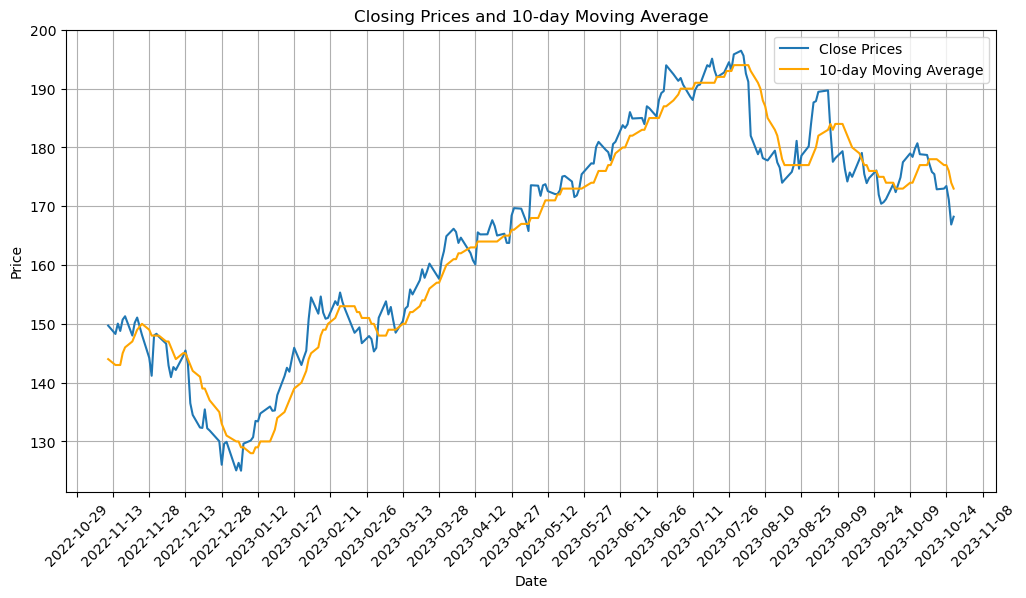

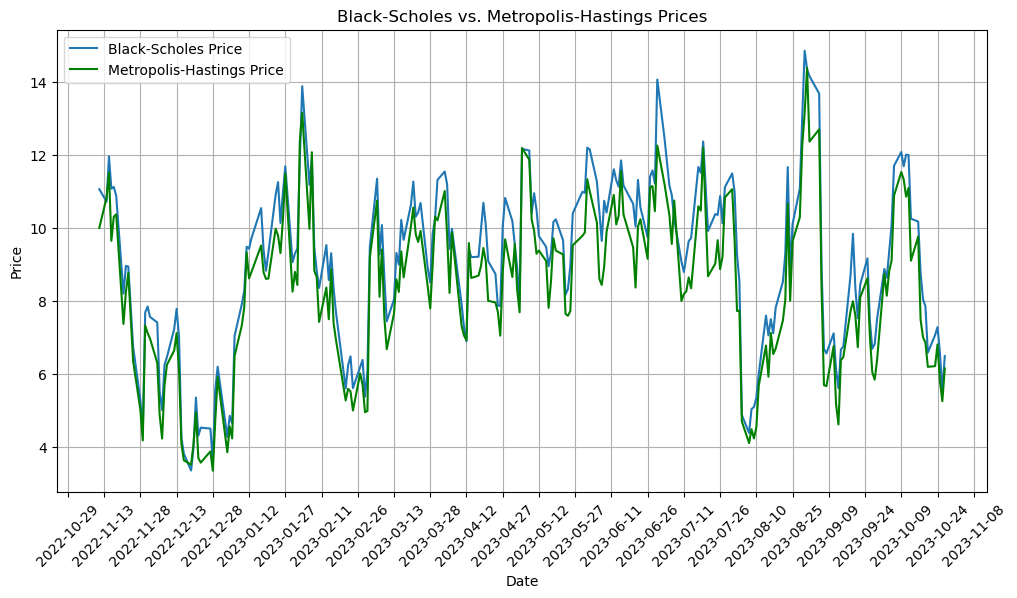

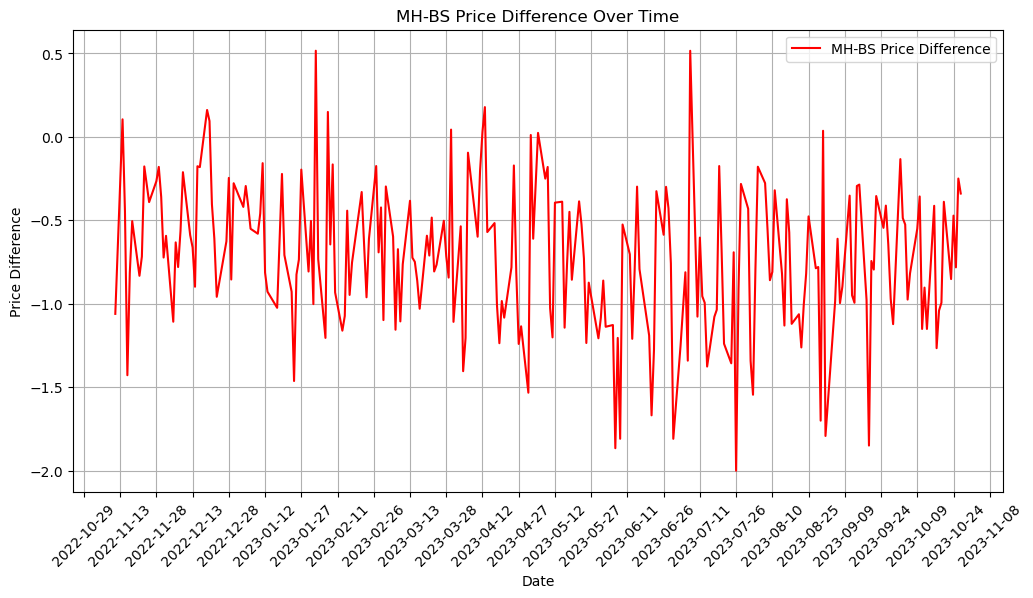

In [20]:
# Import required libraries for visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Assuming data_csv is a DataFrame containing the relevant financial data
data_csv = pd.read_csv("AAPL_option_pricing_comparison.csv")

# Convert the 'Date' column to datetime format for better handling in plotting
data_csv['Date'] = pd.to_datetime(data_csv['Date'])

# Visualization 1: Plotting Closing Prices with 10-day Moving Average
plt.figure(figsize=(12, 6))
plt.plot(data_csv['Date'], data_csv['Close'], label='Close Prices')  # Plotting close prices
plt.plot(data_csv['Date'], data_csv['10_day_MA'], label='10-day Moving Average', color='orange')  # Plotting 10-day MA
plt.title('Closing Prices and 10-day Moving Average')  # Setting title
plt.xlabel('Date')  # Label for x-axis
plt.ylabel('Price')  # Label for y-axis
plt.legend()  # Displaying legend
plt.grid(True)  # Enabling grid for better readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Formatting x-axis labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))  # Setting major tick locator
plt.xticks(rotation=45)  # Rotating x-axis labels for readability
plt.show()  # Displaying the plot

# Visualization 2: Comparing Black-Scholes and Metropolis-Hastings Prices
plt.figure(figsize=(12, 6))
plt.plot(data_csv['Date'], data_csv['BS Price'], label='Black-Scholes Price')  # Plotting Black-Scholes prices
plt.plot(data_csv['Date'], data_csv['MH Price'], label='Metropolis-Hastings Price', color='green')  # Plotting MH prices
plt.title('Black-Scholes vs. Metropolis-Hastings Prices')  # Setting title
plt.xlabel('Date')  # Label for x-axis
plt.ylabel('Price')  # Label for y-axis
plt.legend()  # Displaying legend
plt.grid(True)  # Enabling grid for better readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Formatting x-axis labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))  # Setting major tick locator
plt.xticks(rotation=45)  # Rotating x-axis labels for readability
plt.show()  # Displaying the plot

# Visualization 3: Plotting the Difference in Prices Between MH and BS Over Time
plt.figure(figsize=(12, 6))
plt.plot(data_csv['Date'], data_csv['MH-BS Difference'], label='MH-BS Price Difference', color='red')  # Plotting MH-BS price difference
plt.title('MH-BS Price Difference Over Time')  # Setting title
plt.xlabel('Date')  # Label for x-axis
plt.ylabel('Price Difference')  # Label for y-axis
plt.legend()  # Displaying legend
plt.grid(True)  # Enabling grid for better readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Formatting x-axis labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))  # Setting major tick locator
plt.xticks(rotation=45)  # Rotating x-axis labels for readability
plt.show()  # Displaying the plot

In [21]:
data_csv

,Date,Open,High,Low,Close,Adj Close,Volume,10_day_MA,BS Price,MH Price,MH-BS Difference,MH-BS Percent Difference
0,2022-11-11,145.820007,150.009995,144.369995,149.699997,149.064011,93979700,144.0,11.062304,10.001572,-1.060732,-9.588707
1,2022-11-14,148.970001,150.279999,147.429993,148.279999,147.650055,73374100,143.0,10.723184,10.828200,0.105016,0.979332
2,2022-11-15,152.220001,153.589996,148.559998,150.039993,149.402573,89868300,143.0,11.961454,11.513942,-0.447512,-3.741282
3,2022-11-16,149.130005,149.869995,147.289993,148.789993,148.157883,64218300,143.0,11.075513,9.647250,-1.428263,-12.895681
4,2022-11-17,146.429993,151.479996,146.149994,150.720001,150.079697,80389400,145.0,11.125553,10.310277,-0.815276,-7.327956
...,...,...,...,...,...,...,...,...,...,...,...,...
236,2023-10-23,170.910004,174.009995,169.929993,173.000000,173.000000,55980100,177.0,7.067140,6.215042,-0.852098,-12.057180
237,2023-10-24,173.050003,173.669998,171.449997,173.440002,173.440002,43816600,177.0,7.283247,6.811273,-0.471974,-6.480271
238,2023-10-25,171.880005,173.059998,170.649994,171.100006,171.100006,57157000,176.0,6.586794,5.804822,-0.781972,-11.871817
239,2023-10-26,170.369995,171.380005,165.669998,166.889999,166.889999,70625300,174.0,5.504316,5.254583,-0.249733,-4.537034


-0.7245855545054894
-8.165582943663495


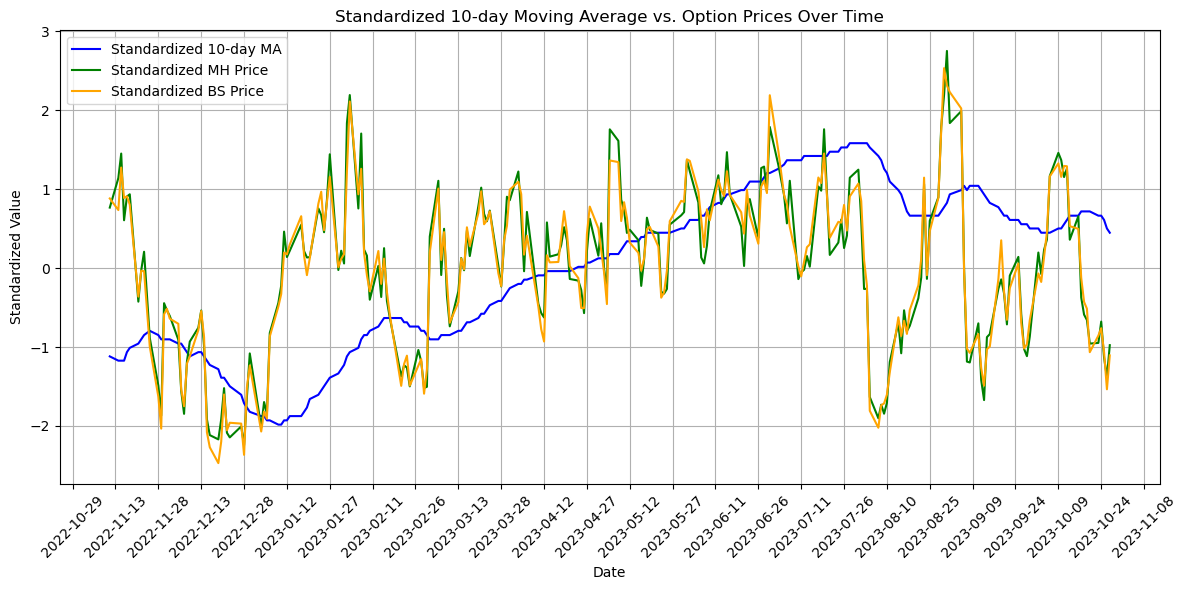

In [22]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Assuming data_csv is the DataFrame containing the financial data including 'Date', '10_day_MA', 'MH Price', and 'BS Price'.

print(np.mean(data_csv['MH-BS Difference']))
print(np.mean(data_csv['MH-BS Percent Difference']))

# Convert 'Date' to datetime for consistent handling and plotting
data_csv['Date'] = pd.to_datetime(data_csv['Date'])

# Preparing the data for standardization
# Reshape the 10-day Moving Average values for compatibility with the scaler
ma_values = data_csv['10_day_MA'].values.reshape(-1, 1)

# Reshape the Metropolis-Hastings Price values similarly
mh_values = data_csv['MH Price'].values.reshape(-1, 1)

# Reshape the Black-Scholes Price values for the scaler
bs_values = data_csv['BS Price'].values.reshape(-1, 1)

# Initialize the standard scaler
scaler = StandardScaler()

# Standardize the 10-day Moving Average, Metropolis-Hastings, and Black-Scholes Prices
data_csv['10_day_MA_standardized'] = scaler.fit_transform(ma_values).flatten()
data_csv['MH_Price_standardized'] = scaler.fit_transform(mh_values).flatten()
data_csv['BS_Price_standardized'] = scaler.fit_transform(bs_values).flatten()

# Visualization of Standardized Values
# Plotting the standardized 10-day Moving Average, Metropolis-Hastings, and Black-Scholes Prices
plt.figure(figsize=(12, 6))
plt.plot(data_csv['Date'], data_csv['10_day_MA_standardized'], label='Standardized 10-day MA', color='blue')
plt.plot(data_csv['Date'], data_csv['MH_Price_standardized'], label='Standardized MH Price', color='green')
plt.plot(data_csv['Date'], data_csv['BS_Price_standardized'], label='Standardized BS Price', color='orange')
plt.title('Standardized 10-day Moving Average vs. Option Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Standardized Value')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the layout to prevent clipping of tick-labels
plt.show()
